In [1]:
#Romi Tshiorny
#Assignment 3 Part 2

import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

data = pd.read_csv("spambase.data")

# Programatically read the names file and retreive the column names
# Only works for that specific format, but makes it so I don't have to do it manually
names = open("spambase.names",'r')
columns = []
extras = []
for line in names:
    if(line.startswith("word")):
        columns.append(line.split(":")[0])
    elif(line.startswith("char") or line.startswith("capital")):
        columns.append(line.split(":")[0])
        extras.append(line.split(":")[0])
        
names.close()
columns.append('spam')

data.columns = columns
data.sample(frac=1).reset_index(drop=True)

#Mix up data because it came order by spam/ham
data = shuffle(data, random_state = 0)


#Drop unnccesary columns. 
#Here I'm assuming that all the punctuation symbols don't contribute to ham/spam
#Also dropping all the run_length(s) because they muddy the Bayesian appraoch.
data = data.drop(extras,axis=1)

data.head()


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,spam
991,0.00,0.0,0.81,0.0,0.81,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2824,1.16,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1906,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1471,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1813,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.85,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [2]:
#Split the data into training and testing sets

train, test = train_test_split(data, test_size = 0.25, random_state = 0)

train_X = train.drop(['spam'],axis=1)
test_X = test.drop(['spam'],axis=1)

train_Y = train.drop(train_X.columns,axis=1)
test_Y = test.drop(test_X.columns,axis=1)

In [3]:
# Class for a naive bayes classifier
class NaiveBayes:
    def __init__(self):
        self.total_samples = 0
        self.positive_prob = 0
        self.negative_prob = 0
        self.positive_class_probs = None
        self.negative_class_probs = None
    
    # Method for fitting the Naive Bayes to the data
    def fit(self, X, Y):   
        #Count the total amount of positive and negative cases
        pos_count = 0
        neg_count = 0
        positives = [0]*len(X[0])
        negatives = [0]*len(X[0])
        for i in range(len(X)):
            if Y[i] == 0:
                neg_count += 1
            else:
                pos_count += 1
            
            # Add the frequency to the total frequency of each attribute
            for j in range(len(X[i])):
                if Y[i] == 0:
                    negatives[j] += X[i][j]
                else:
                    positives[j] += X[i][j]
                    
        total_positive = 0
        total_negative = 0
        # Add 0.1 to every frequency to avoid the case of '0' probability
        for i in range(len(positives)):
            positives[i] += 0.1
            negatives[i] += 0.1
            
            total_positive += positives[i]
            total_negative += negatives[i]
            
        #Fill the probabilites for each attribute:
        self.positive_class_probs = [0]*len(positives)
        self.negative_class_probs = [0]*len(negatives)
        for i in range(len(positives)):
            self.positive_class_probs[i] = positives[i]*100/total_positive
            self.negative_class_probs[i] = negatives[i]*100/total_negative
            
            
        self.total_samples = pos_count + neg_count
        self.positive_prob = pos_count/(self.total_samples)
        self.negative_prob = 1 - self.positive_prob
        
    #Find percent of correct guesses
    def score(self,X,Y):
        success_count = 0
        for i in range(len(X)):
            y_true = Y[i]
            y_pred = self.predict(X[i])
            if(y_true==y_pred):
                success_count +=1
                          
        return success_count/len(X)
    
    # Classify a new sample
    def predict(self,X):
        
        pos_score = self.positive_prob
        neg_score = self.negative_prob
        for i in range(len(X)):
            if(X[i] > 0):
                pos_score *= self.positive_class_probs[i]
                neg_score *= self.negative_class_probs[i]
            
        return 1 if pos_score > neg_score else 0
        
    # Return the probabilties of provided samples being positive and negative class
    def predict_proba(self, X):
        
        probs = []
        for i in range(len(X)):
            pos_score = self.positive_prob
            neg_score = self.negative_prob
            for j in range(len(X[i])):
                if(X[i][j] > 0):
                    pos_score *= self.positive_class_probs[j]
                    neg_score *= self.negative_class_probs[j]
                    
            # Normalize probabilities
            total = pos_score + neg_score
            probs.append((neg_score/total,pos_score/total))
            
        return probs
    
    #Method for getting true positive/negative and false positive/negative
    def accuracy_breakdown(self,X,Y):
        tp_count = 0
        fp_count = 0
        tn_count = 0
        fn_count = 0
        for i in range(len(X)):
            y_pred = self.predict(X[i])
            y_true = Y[i]
            #if result should be positive:
            if(y_true == 1):
                #True positive
                if(y_pred == y_true):
                    tp_count += 1
                #False negative
                else:
                    fn_count += 1     
            #if result should be negative:
            else:
                #True negative
                if(y_pred == y_true):
                    tn_count += 1
                #False positive
                else:
                    fp_count += 1
            
        return tp_count, fp_count, tn_count, fn_count
            
        



In [4]:
bayes_model = NaiveBayes()
bayes_model.fit(train_X.values,train_Y.values.ravel())

<AxesSubplot:>

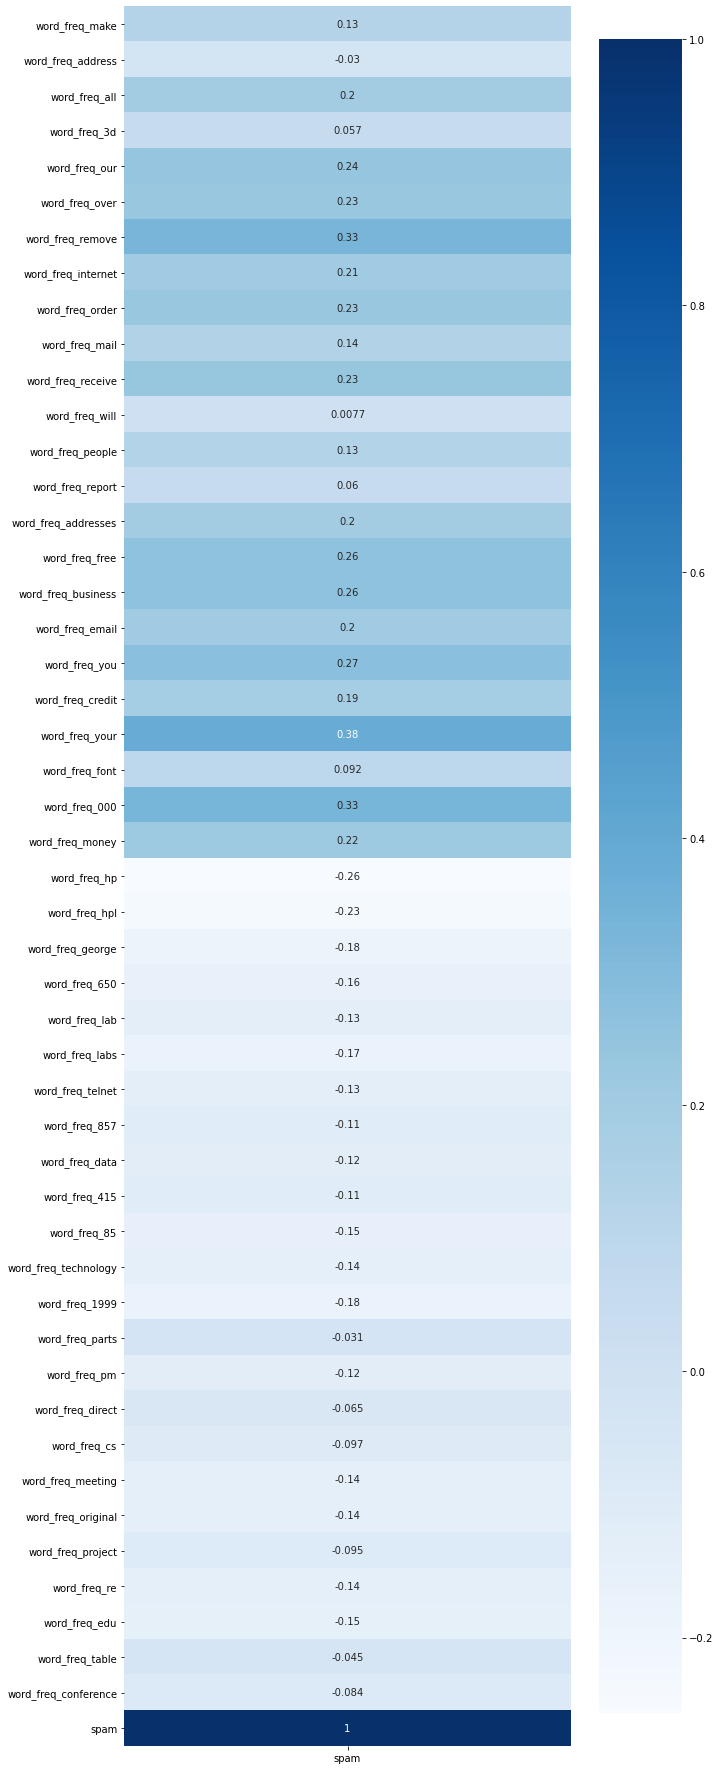

In [5]:
#The following diagram shows how the frequency of each word correlates with
# the liklihood of it being spam.

plt.figure(figsize=(10,32))
sb.heatmap(data.corr()[['spam']], annot=True,cmap = 'Blues')

In [6]:
from sklearn.metrics import confusion_matrix
#Compute the accuracy precision and recall

true_pos, false_pos, true_neg, false_neg = bayes_model.accuracy_breakdown(test_X.values,test_Y.values.ravel())

accuracy = bayes_model.score(test_X.values,test_Y.values.ravel())
precision = (true_pos)/(true_pos + false_pos)
recall = (true_pos)/(true_pos+false_neg)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)

#Confusion matrix

predicted = []
for v in test_X.values:
    predicted.append(bayes_model.predict(v))

print("Confusion Matrix:")
print(confusion_matrix(test_Y.values.ravel(),predicted))

Accuracy:  0.8956521739130435
Precision:  0.8213592233009709
Recall:  0.9379157427937915
Confusion Matrix:
[[607  92]
 [ 28 423]]


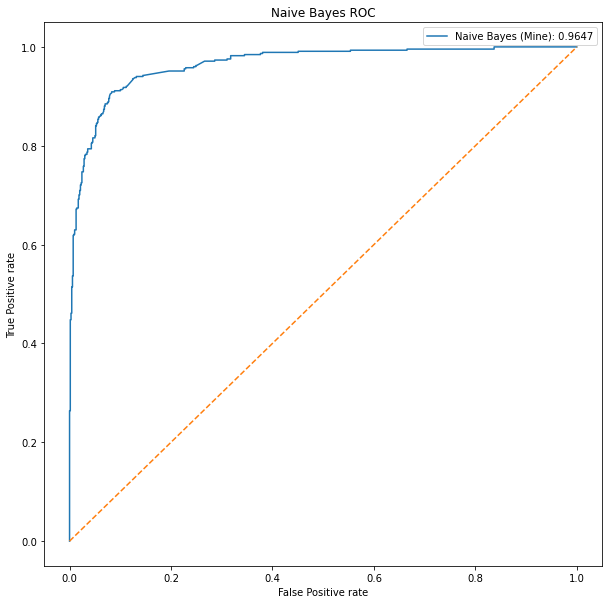

In [7]:
# AUC-ROC Plot

probs =  bayes_model.predict_proba(test_X.values)
naive_probs = []
for p in probs:
    naive_probs.append(p[1])
    
naive_fpr, naive_tpr, naive_thresh = roc_curve(test_Y,naive_probs)

naive_score = roc_auc_score(test_Y,naive_probs)

plt.figure(figsize = (10,10))

plt.plot(naive_fpr,naive_tpr,label = 'Naive Bayes (Mine): {}'.format(naive_score.round(4)))

plt.plot([0,1],[0,1],linestyle = 'dashed') # Diagonal

plt.title("Naive Bayes ROC")
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

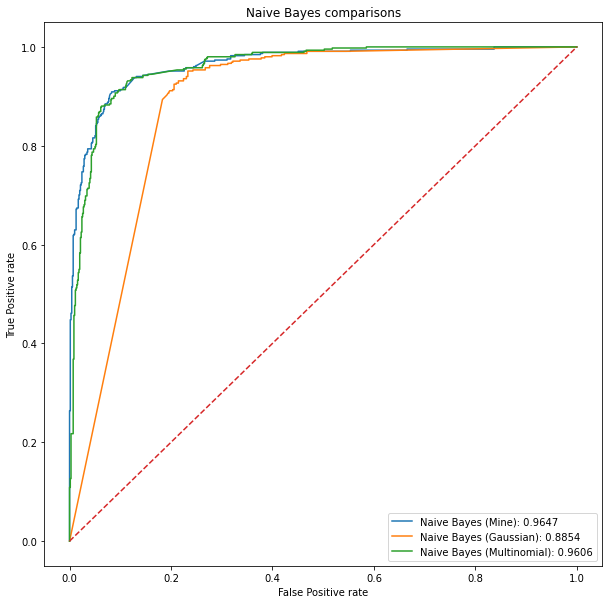

In [8]:
# Comparison of my naive bayes to some of the scikit ones

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

bayes_model_G = GaussianNB()
bayes_model_M = MultinomialNB()

bayes_model_G.fit(train_X,train_Y.values.ravel())
bayes_model_M.fit(train_X,train_Y.values.ravel())

bayes_prob_G = bayes_model_G.predict_proba(test_X)[:,1]
bayes_prob_M = bayes_model_M.predict_proba(test_X)[:,1]

bayes_fpr_G, bayes_tpr_G, bayes_thresh_G = roc_curve(test_Y,bayes_prob_G)
bayes_fpr_M, bayes_tpr_M, bayes_thresh_M = roc_curve(test_Y,bayes_prob_M)

bayes_score_G = roc_auc_score(test_Y,bayes_prob_G)
bayes_score_M = roc_auc_score(test_Y,bayes_prob_M)

plt.figure(figsize = (10,10))

plt.plot(naive_fpr,naive_tpr,label = 'Naive Bayes (Mine): {}'.format(naive_score.round(4)))
plt.plot(bayes_fpr_G, bayes_tpr_G, label = 'Naive Bayes (Gaussian): {}'.format(bayes_score_G.round(4)))
plt.plot(bayes_fpr_M, bayes_tpr_M, label = 'Naive Bayes (Multinomial): {}'.format(bayes_score_M.round(4)))

plt.plot([0,1],[0,1],linestyle = 'dashed') # Diagonal

plt.title("Naive Bayes comparisons")
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.legend()
plt.show()

As we see above, my Naive Bayes filter performs significantly better than sci-kits Gaussian Bayes and very slightly better (almost identical to) the Multinomial Bayes.